In [1]:
import sys
sys.path.insert(0, '../../../')

import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings, balanced_subsample
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
path_to_db='../../../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [5]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        folds=5,
                        random_state=42
                       )

In [6]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
count,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,...,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000,34722.000000
mean,63.941713,65.665808,49.632212,47.134655,39.367883,38.405211,35.596640,34.617313,34.043460,33.051667,...,0.043403,-0.035679,44.485960,42.633316,22.385889,20.838246,14.816204,0.649214,24.570272,5.503312
std,22.376017,25.318529,16.301524,16.150300,13.220590,12.982169,11.866078,11.593986,11.519877,11.308873,...,0.227452,0.223848,3912.281113,1138.943868,823.741668,23.863441,558.972694,0.477223,14.529925,2.884408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.818966,-0.829031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,50.824509,50.057023,40.173008,37.449289,31.674154,30.582568,28.531641,27.543796,27.073887,26.078358,...,-0.119544,-0.201310,7.799437,14.144807,3.960294,14.426031,2.324031,0.000000,12.000000,3.000000
50%,63.919076,64.288338,50.024940,47.703741,39.806559,39.278398,36.428501,35.475993,34.867461,33.987164,...,0.046015,-0.036857,9.326971,17.195005,4.837236,16.532026,3.292253,1.000000,24.000000,6.000000
75%,77.246154,80.527143,59.618815,57.470015,47.556487,46.869206,43.462863,42.469852,41.817290,40.769021,...,0.212199,0.127219,11.923360,21.039314,5.754140,19.802342,4.699188,1.000000,37.000000,8.000000
max,194.608514,222.926306,138.137718,121.432810,116.077974,104.890146,85.615582,106.012983,93.750817,83.565897,...,0.955219,0.727482,719565.658035,112918.767938,82663.870817,563.421832,67986.785970,1.000000,49.000000,10.000000


In [7]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df[df.fold != 1], test_size=0.20, random_state=42)

In [8]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']

In [9]:
train_X, train_y = balanced_subsample(train_X, train_y)

# Training

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=90)),
    ('feat_red', LinearDiscriminantAnalysis(n_components=10, solver='eigen')),
    ('classify', KNN(n_neighbors=15, algorithm='ball_tree'))
])

params = {
          'classify__n_neighbors': range(5,25,1),
          'classify__algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

grsrch = GridSearchCV(clf, params, cv=5, n_jobs=10)

grsrch.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function f_classif at 0x7f14f02d5a60>)), ('feat_red', LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='eigen...',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'classify__n_neighbors': range(5, 25), 'classify__algorithm': ('ball_tree', 'kd_tree', 'brute')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
sorted(grsrch.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_classify__algorithm',
 'param_classify__n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.6498079385403329
Confusion matrix, without normalization
[[1420  724]
 [1464 2640]]


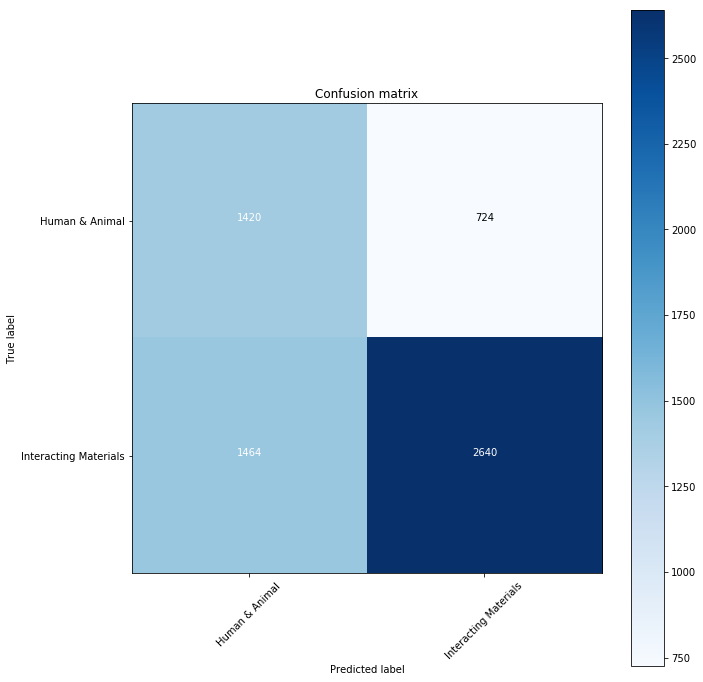

In [12]:
pred = grsrch.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [13]:
all_df = df[df.fold == 1]

In [14]:
all_df.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
487,75.165352,66.866578,44.694009,33.174963,35.093786,64.763460,33.757902,38.463485,30.710835,29.359358,...,0.117234,-0.198603,7.731724,11.288856,3.192496,12.190021,3.345647,0,8,1
488,80.304867,71.975604,41.917320,34.356471,33.573010,59.741558,32.513543,31.914037,36.854144,34.011251,...,0.019220,0.161641,7.204404,10.524987,3.035072,11.523270,2.944568,0,8,1
489,60.777285,122.149155,50.720902,29.958488,67.894455,44.822708,22.716957,29.545133,32.443571,32.277866,...,-0.108703,0.013367,9.164510,9.779612,3.024563,7.718257,2.951216,0,8,1
490,73.204304,53.083415,38.383215,66.848552,62.349346,38.266288,33.737663,25.222149,30.633048,25.031185,...,0.202843,-0.290614,7.021112,12.669324,2.568839,7.831026,3.565995,0,8,1
491,77.841182,44.483553,42.363173,50.229772,39.473519,29.123045,32.640542,34.475095,27.004278,18.909267,...,0.284115,-0.455202,7.999813,15.118770,4.626891,10.053996,3.933323,0,8,1


In [15]:
X = all_df.drop(['target', 'h_target', 'fold'], axis=1)
y = all_df['h_target']

0.6341183228029867
Confusion matrix, without normalization
[[ 744  422]
 [ 852 1464]]


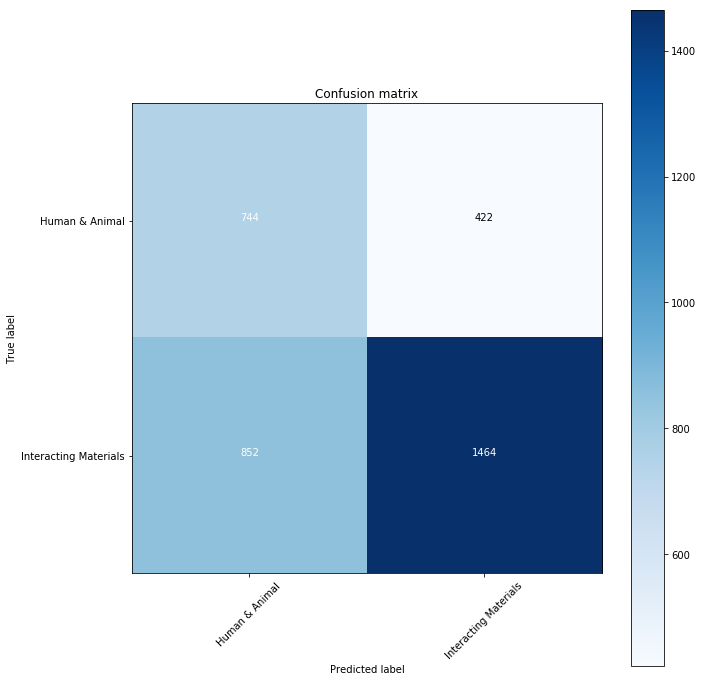

In [16]:
pred = grsrch.predict(X)
pred_prob = grsrch.predict_proba(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [17]:
grsrch.best_estimator_ 

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=90, score_func=<function f_classif at 0x7f14f02d5a60>)), ('feat_red', LinearDiscriminantAnalysis(n_components=10, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), ('classify', KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=23, p=2,
           weights='uniform'))])

In [18]:
import seaborn as sns
misclassified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

correctly_classified = {
    'Predicted h_target': [],
    'Actual target': [],
    'Anim_prob': [],
    'Interact_prob': []
}

for row, p, prob, Y in zip(all_df.iterrows(), pred, pred_prob, y):
    Y = int(Y)
    p = int(p)
    if p!=Y:
        misclassified['Actual target'].append(classes[int(row[1]['target'])])
        misclassified['Predicted h_target'].append(h_classes[p])
        misclassified['Anim_prob'].append(prob[0])
        misclassified['Interact_prob'].append(prob[1])
    else:
        correctly_classified['Actual target'].append(classes[int(row[1]['target'])])
        correctly_classified['Predicted h_target'].append(h_classes[p])
        correctly_classified['Anim_prob'].append(prob[0])
        correctly_classified['Interact_prob'].append(prob[1])

misclassified = pd.DataFrame.from_dict(misclassified)
correctly_classified = pd.DataFrame.from_dict(correctly_classified)

In [19]:
average_prob = misclassified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.667585,0.332415
Interacting Materials,0.333814,0.666186


In [20]:
average_prob = misclassified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.616977,0.383023
breathing,0.420290,0.579710
brushing_teeth,0.659847,0.340153
can_opening,0.698488,0.301512
car_horn,0.649068,0.350932
cat,0.347826,0.652174
chainsaw,0.683230,0.316770
chirping_birds,0.327060,0.672940
church_bells,0.686779,0.313221


In [21]:
average_prob = correctly_classified.groupby('Predicted h_target').mean()
average_prob.head()

,Anim_prob,Interact_prob
Predicted h_target,,
Human & Animal,0.705587,0.294413
Interacting Materials,0.281866,0.718134


In [22]:
average_prob = correctly_classified.groupby('Actual target').mean()
average_prob

,Anim_prob,Interact_prob
Actual target,,
airplane,0.305523,0.694477
breathing,0.721968,0.278032
brushing_teeth,0.226234,0.773766
can_opening,0.340153,0.659847
car_horn,0.312500,0.687500
cat,0.732987,0.267013
chainsaw,0.305750,0.694250
chirping_birds,0.639752,0.360248
church_bells,0.380435,0.619565


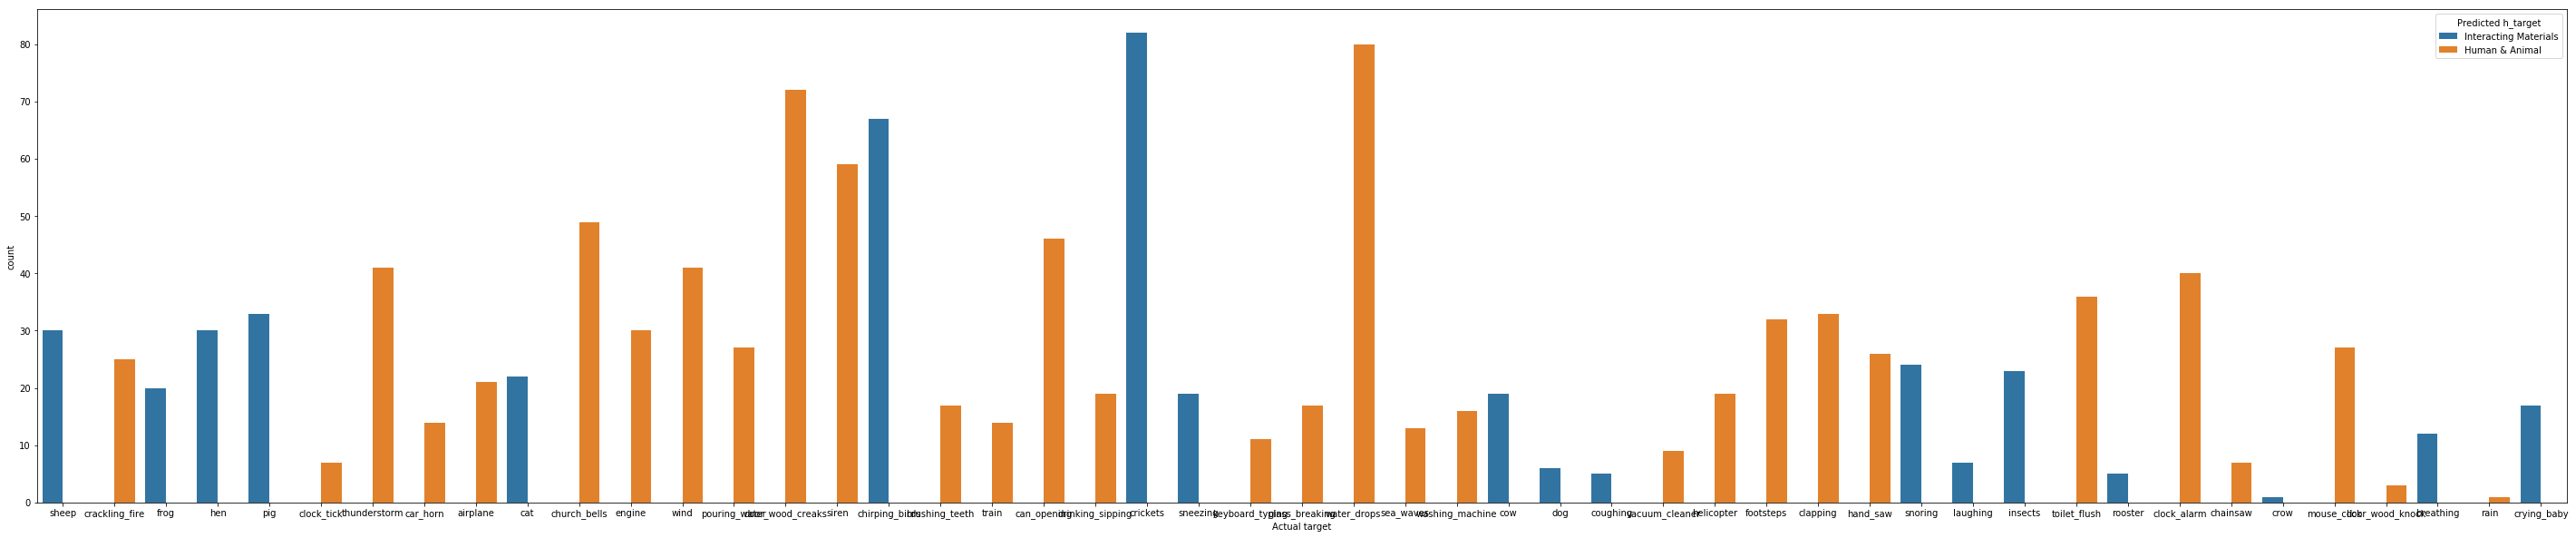

In [23]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='Actual target', hue='Predicted h_target',data=misclassified)